## Neccesary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("darkgrid")
import cv2

from glob import glob
from time import time
from pprint import pprint
import sys
from random import sample
import shutil

from utils import calibrate_images, tprint

In [2]:
cv2.__version__

'4.3.0'

## Find Checkerboard Corners

In [4]:
imagesL = glob(f"../Left/*.jpg")
imagesR = glob(f"../Right/*.jpg")

imagesL.sort()
imagesR.sort()

# Specify the dimension of checkboard pattern (N-1*M-1) , where N is the number of columns while M is number of rows
CHECKERBOARD = (14,9)
num_squares = CHECKERBOARD[0] * CHECKERBOARD[1]

# Specify the size of square in cm
squareSize = 3
    
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)


objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0],0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp = objp*squareSize

_img_shape = None
objpoints = []
imgpointsL = []
imgpointsR = []

for i in range(len(imagesL)):
    try:
        imgL = cv2.imread(imagesL[i])
        imgR = cv2.imread(imagesR[i])
        
        grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
        grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
        
        flags_corners =  (
            cv2.CALIB_CB_ADAPTIVE_THRESH
            + cv2.CALIB_CB_FAST_CHECK
            + cv2.CALIB_CB_NORMALIZE_IMAGE
            + cv2.fisheye.CALIB_CHECK_COND
        )
        
        retL, cornersL = cv2.findChessboardCorners(grayL, CHECKERBOARD, flags_corners)
        retR, cornersR = cv2.findChessboardCorners(grayR, CHECKERBOARD, flags_corners)
    
        if (retL and retR):
            objpoints.append(objp)
            cv2.cornerSubPix(grayL, cornersL, (3,3), (-1,-1), subpix_criteria)
            cv2.cornerSubPix(grayR, cornersR, (3,3), (-1,-1), subpix_criteria)
            
            cornersL = cornersL.reshape(1,num_squares,2)
            cornersR = cornersR.reshape(1,num_squares,2)
            
            imgpointsL.append(cornersL)
            imgpointsR.append(cornersR)
            
            sys.stdout.write(f"\r{i} : {cornersL.shape}")
            sys.stdout.flush()
    except:
        print(sys.exc_info())
        continue

N_OK = len(imgpointsL)

78 : (1, 126, 2)

In [5]:
imgpointsL[0].shape, objpoints[0].shape

((1, 126, 2), (1, 126, 3))

In [6]:
print("Numberf of read stereo pair for calibration: ", N_OK)

78

## Calibrate both cameras

In [ ]:
FLAGS = (
    cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
    + cv2.fisheye.CALIB_CHECK_COND
    + cv2.fisheye.CALIB_FIX_SKEW
    + cv2.fisheye.CALIB_USE_INTRINSIC_GUESS
)

In [ ]:
# Initial Guess
k = np.array([[700.0,0.0,800.0],
              [0.0,700.0,500.0],
              [0.0,0.0,1.0]])
d = np.array([[0.02],
              [0.02],
              [0.02],
              [0.02]])

# Pixel Size of an Image
DIM = (1920, 1200)              
rmsL, K_L, D_L, _, _ = calibrate_images(imgpointsL, objpoints, DIM, k, d, FLAGS)

In [ ]:
k = np.array([[700.0,0.0,800.0],
              [0.0,700.0,500.0],
              [0.0,0.0,1.0]])
d = np.array([[0.02],
              [0.02],
              [0.02],
              [0.02]])
rmsR, K_R, D_R, _, _ = calibrate_images(imgpointsR, objpoints, DIM, k, d, FLAGS)

In [ ]:
K_L, K_R

(array([[777.77998193,   0.        , 978.30522567],
        [  0.        , 778.21797569, 574.20560784],
        [  0.        ,   0.        ,   1.        ]]),
 array([[779.29366996,   0.        , 991.01858361],
        [  0.        , 779.87254618, 587.79053545],
        [  0.        ,   0.        ,   1.        ]]))

In [ ]:
print(D_L,"\n\n", D_R)

[[ 0.05002752]
 [ 0.08558243]
 [-0.08005675]
 [ 0.02056243]] 

 [[ 0.04452034]
 [ 0.10028073]
 [-0.09549254]
 [ 0.02591574]]


## Stereo calibrate and rectify

In [ ]:
ret, K_L, D_L, K_R, D_R, R, T = \
    cv2.fisheye.stereoCalibrate(
            objpoints,
            imgpointsL, imgpointsR,
            K_L, D_L,
            K_R, D_R,
            DIM,
            flags=cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_USE_INTRINSIC_GUESS,
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6),
        )

R_L, R_R, P_L, P_R, Q = \
    cv2.fisheye.stereoRectify(
            K_L, D_L,
            K_R, D_R,
            DIM,
            R,
            T,
            balance=1,
            flags=cv2.CALIB_ZERO_DISPARITY
        )

## Undistort the image

In [ ]:
mapL1, mapL2 = cv2.fisheye.initUndistortRectifyMap(K_L, D_L, R_L, P_L, DIM, cv2.CV_16SC2)
mapR1, mapR2 = cv2.fisheye.initUndistortRectifyMap(K_R, D_R, R_R, P_R, DIM, cv2.CV_16SC2)

trans_id = "000"
img_id = "01158"

left_image_path = f"../calib/{trans_id}/image_{img_id}_192.168.10.72.jpg"
right_image_path = f"../calib/{trans_id}/image_{img_id}_192.168.10.69.jpg"

imgL = cv2.imread(left_image_path)
imgR = cv2.imread(right_image_path)

undistorted_imgL = cv2.remap(imgL, mapL1, mapL2,
                               interpolation=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT)
undistorted_imgR = cv2.remap(imgR, mapR1, mapR2,
                               interpolation=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT)

## Plot results

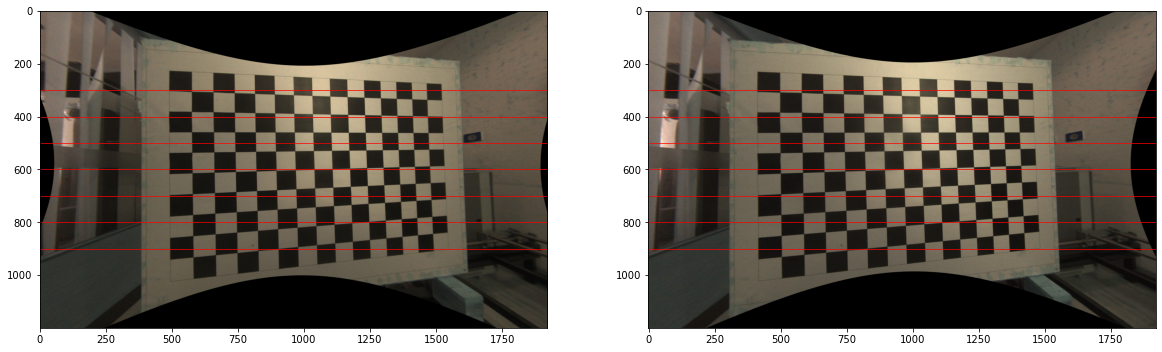

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,15))
axes[0].imshow(undistorted_imgL)
axes[1].imshow(undistorted_imgR)

Ys = [300,400,500,600,700,800,900]
for y in Ys:
    axes[0].axhline(y=y, color='r', linestyle='-', linewidth=0.7)
    axes[1].axhline(y=y, color='r', linestyle='-', linewidth=0.7)